# Autopilot Blueprint and Trusted AI Guide

This notebook guides you through the process of using a no-code ML pipeline (blueprint) to deliver an optimized ML model. The workflow uses:

 * [Amazon SageMaker DataWrangler](https://aws.amazon.com/sagemaker/data-wrangler/) for data prep. It provdies a graphical interface for creating data prep flows. 
 * [Amazon SageMaker Autopilot](https://aws.amazon.com/sagemaker/autopilot/) for mode creation. It provides AutoML on tabular data through a fully managed experience.
 * [Amazon SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/) and [Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html) capabilities are used to facilitate Trusted AI.

#### Leaning Objectives

 * Learn how to use the AutoML blueprint.
 * Learn the facilities available to you to facilitated Trusted AI.
 * Deploy a real-time hosted model endpoint that is ready for integration into your analytics systems.
 
#### The Data

This notebook uses the [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) as an example. This tabular dataset contains the results of a marketing campaign to acquire customers for term deposits. Each record represents information about a prospect. The last column is the target variable. It contains information of whether the prospect subscribed to the term deposit. <br><br>_Citation: Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014_

#### Compatibility

* __Amazon SageMaker DataWrangler:__ design and tested for 
  * Flow definition schema: 1.0
  * DataWrangler Processing Container: 1.3.0
  

* __Amazon SageMaker Clarify:__ designed and tested for
  * Bias processing container: 1.0
  * XAI processing container: 1.0
  
* __Amazon SageMaker Studio:__ this notebook was designed and tested on
  * Python3 (Data Science) Kernel
  * Amazon SageMaker SDK version 2.x

You can contact me regarding issues with the blueprint and notebook: <a href="mailto:dylatong@amazon.com">Dylan Tong, AWS</a>

---

## Prerequsites

1. This notebook requires access to Amazon S3, StepFunctions, and SageMaker. Attach the following managed policies to your Amazon SageMaker Studio execution role:

  * AmazonSageMakerFullAccess
  * AWSStepFunctionsFullAccess
  * AmazonS3FullAccess
  
  
2. Deploy the [Autopilot Blueprint CloudFormation template]( https://dtong-public-fileshares3-us-west-2.amazonaws.com/automl-blueprint/code/cf/automl-blueprint.yml) before you continue further. You can deploy the template from the console by providing the following TemplateURL: https://dtong-public-fileshares3-us-west-2.amazonaws.com/automl-blueprint/code/cf/automl-blueprint.yml. <br> <br> Use the __default settings__ or you will be required to modify the code in this notebook.

 ![Deploy Blueprint Video](img/cf-deploy-bp.gif)

3. Optionally, [clone the Github repository](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-tasks-git.html) over to your Amazon SageMaker Studio instance.

  ![Setup Git Video](img/sm-setup-git.gif)

  The blueprint consists of the following assets:

  * __code/deploy:__ the CloudFormation template to deploy the solution.
  * __code/workflow/implementations/autopilot:__ contains the Lambda function code executed as part of a StepFunction workflow. This workflow implemention orchestrates SageMaker DataWrangler, Autopilot, Clarify and other core SageMaker processes. 
  * __code/workflow/layers:__ contains Amazon SageMaker dependencies required by the workflow. These dependencies are deployed as a Lambda Layer.
  * __config/blueprint-config.json:__ this file contains parameters you can configure to change the behavior of the blueprint. The blueprint looks for this configuration file in the S3 bucket that you configured as your workspace. The file should be stored under the prefix /config.
  * __meta/uci-bank-marketing-dataset.flow:__ this is a sample flow file produced by DataWrangler. You can create and save your own flow file in your workspace under the /meta prefix. You will need to reconfigure blueprint-config.json to use your flow file.
  * __notebook:__ this directory contains the assets for this notebook.

___

#### Install Dependencies
Run the following to install dependencies that aren't included with the Python 3 (Data Science) Kernel by default.

In [ ]:
!conda install -y -c conda-forge tqdm shap

#### Initialize Notebook

Run the following to assign global variables and import the required libraries.

In [5]:
import json
import os

import numpy as np
import boto3

from utils.bpconfig import BPConfig
from utils.viz import ModelInspector
from utils.wf import SFNMonitor,  BPRunner
import utils.wf, utils.bpconfig, utils.flow

sfn = boto3.client("stepfunctions")
sm = boto3.client("sagemaker")
s3 = boto3.client("s3")

account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name
workspace = f"bp-workspace-{region}-{account_id}"
bpconfig = BPConfig.get_config(workspace, os.getcwd())
local_dir = os.getcwd()

bprunner = BPRunner(workspace, py_driver=sfn)

## If you modified the Cloudformation default parameters, you will need to update wf_name accordingly.
WF_NAME = "bp-autopilot-blueprint"

---

### [Optional] View Pre-training Analysis Reports and Data Flow

This notebook includes a sample flow file for prepping the UCI bank marketing dataset. It includes examples of analysis reports created with Amazon SageMaker DataWrangler for target leakage and data bias analysis.

Run the following cell to download the sample flow.


In [15]:
fname = utils.flow.copy_sample_flow_to_local(workspace, local_dir)
print(f"The flow definition file was copied to {fname}")

The flow definition file was copied to /root/automl-blueprint/notebook/uci-bank-marketing-dataset.flow


---

Launch the DataWrangler GUI from the flow definition file and navigate to the analysis reports as shown below.

![DataWrangler Analysis Reports](img/dw-analysis-reports.gif)



---
The target leakage report should look like the following:


![Target Leakage Report](img/target-leakage-report.png)

---
The data bias analysis report should look like the following:

![Data Bias Report](img/data-bias-report.png)

___

### Run the AutoML Blueprint

By now, the CloudFormation template should be in the COMPLETED status. The template will create a StepFunction workflow which will orchestrate the process of data preparation, model creation using AutoML and model evaluation.


Run the following cell to find the ARN of the blueprint workflow that was created in your account.

In [6]:
wf_arn = utils.wf.find_sfn_arn(sfn, WF_NAME)
print(f"Found the resource id of your workflow: {wf_arn}")

Found the resource id of your workflow: arn:aws:states:us-west-1:803235869972:stateMachine:bp-autopilot-blueprint


---
This blueprint is designed to provide a serverless and no-code experience. As you a user, you provide:

1. Raw data
2. An Amazon SageMaker DataWrangler flow created through the GUI
3. Blueprint configurations

Run the cell below to view the default configurations. You don't need to change any of the settings for this tutorial.

In [2]:
config = BPConfig.get_config(workspace, local_dir)
print(f"\n The blueprint configurations were downloaded to {local_dir}/blueprint-config.json \n")
config.print()


 The blueprint configurations were downloaded to /root/automl-blueprint/notebook/blueprint-config.json 

{
    "automl-config": {
        "job_base_name": "automl-bp",
        "max_candidates": "1",
        "metric_name": "AUC",
        "minimum_performance": 0.9,
        "problem_type": "BinaryClassification",
        "target_name": "target"
    },
    "bias-analysis-config": {
        "bias-config": {
            "facet_name": "age",
            "facet_values_or_threshold": [
                30
            ],
            "group_name": "job",
            "label_values_or_threshold": [
                1
            ]
        },
        "instance_count": 1,
        "instance_type": "ml.c5.xlarge",
        "job_base_name": "bp-clarify-bias",
        "output_prefix": "eval/bias",
        "prediction-config": {
            "label": null,
            "label_headers": null,
            "probability": 0,
            "probability_threshold": 0.8
        }
    },
    "data-config": {
        "

___
Run the following cell to execute the blueprint workflow.

In [2]:
execution_arn = bprunner.run_blueprint(WF_NAME, wait=False)

Workflow Initiated:   0%|          | 0/10 [00:00<?, ?it/s]

Exception: Workflow execution FAILED.

---

You have the option to monitor the workflow progress from the StepFunctions console, or from this notebook. Run the next cell to obtain the link to the StepFunction workflow console.


In [8]:
from IPython.display import Markdown as md

sfn_console = f"https://{region}.console.aws.amazon.com/states/home?region={region}#/executions/details/{execution_arn}"

md(f"<img src='img/sfn-bp-workflow.png' width=50%, align='right'/> </br> \
   You can monitor the progress of your workflow from the StepFunctions console: </br> </br>\
   {sfn_console}</br></br> \
   Alternatively, you can run the cell below to monitor the progress from your notebook.")

<img src='img/sfn-bp-workflow.png' width=50%, align='right'/> </br>    You can monitor the progress of your workflow from the StepFunctions console: </br> </br>   https://us-west-1.console.aws.amazon.com/states/home?region=us-west-1#/executions/details/arn:aws:states:us-west-1:803235869972:execution:bp-autopilot-blueprint:9f84594f-274d-4d1e-9a2b-54dc5d0c496e</br></br>    Alternatively, you can run the cell below to monitor the progress from your notebook.

---

Run the following cell if you like to render a progress bar to monitor the progress of the workflow.


In [14]:
SFNMonitor().run(execution_arn)

Workflow Initiated:   0%|          | 0/10 [00:00<?, ?it/s]

>> Parallel Stage: Error Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

>> Parallel Stage: XAI Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

>> Parallel Stage: Bias Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

___

### [Optional] Understand the AutoML Process

This notebook runs the blueprint with Amazon SageMaker Autopilot as the AutoML engine. Autopilot provides transparency into the AutoML process, so you can optionally inspect the automated data profiling and pipeline generation code that gets executed by Autopilot's distributed processing.

The blueprint configurations are set to have Autopilot explore one candidate to minimize the time and cost of this tutorial. However, this isn't practical. In practice, you want Autopilot to explore many candidates resulting in Autopilot to experiment with multiple algorithms and feature processing steps to discover the pipeline that produces the highest performing model on your dataset.

The following steps serve as examples, but won't provide interesting insights. If you like to aim for a production quality type model, you can change the _max_candidates_ configuration to the default value of 250. 

___

Optionally, uncomment the following code to modify the blueprint configuration file and re-run the blueprint workflow. This will result in a higher quality model and the remainder of the notebook will provide more practical model insights. Regardless, the remainder of the notebook will guide you the steps that you take in practice.


In [ ]:
MAX_CANDIDATES = 250
MINIMUM_PERFORMANCE = 0.93

automl_config = {
  "job_base_name": "automl-bp",
  "max_candidates": MAX_CANDIDATES,
  "target_name": "target",
  "problem_type": "BinaryClassification",
  "metric_name": "AUC",
  "minimum_performance": MINIMUM_PERFORMANCE
}
# Update the blueprint configuration. Note that you can modify the json configuration file directly.
# You could build a GUI inteface in place of the json configuration file.
config.update_automl_config(automl_config)

# Rerun the workflow.
execution_arn = bprunner.run_blueprint(WF_NAME, wait=True)

print(f"StepFunction workflow has completed. The execution Id is: {execution_arn}.")

Workflow Initiated:   0%|          | 0/10 [00:00<?, ?it/s]

---

You can inspect the data profiling and candidate pipeline generation steps from notebooks that were generated as part of your Amazon SageMaker Autopilot job. The following video shows how you can navigate to these notebooks.

[todo]

---

### Evaluate your Model

At this point, your workflow should have completed successfully. We can now inspect our model further.

Run the following cell to configure our Model Inspector.


In [16]:
inspector_params = {
    "workspace": workspace,
    "prefixes": {
        "results_path": "automl-blueprint/eval/error",
        "bias_path": "automl-blueprint/eval/bias",
        "xai_path": "automl-blueprint/eval/xai"
    },
    "results-config":{
        "gt_index": 0,
        "pred_index": 1,
    }
}

inspector = ModelInspector(inspector_params)

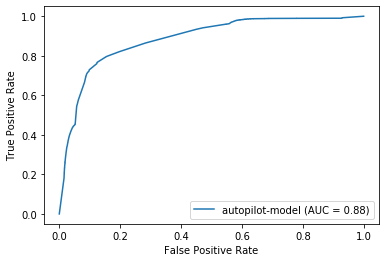

In [17]:
_, _, fpr, tpr, thresholds = inspector.get_roc_curve()

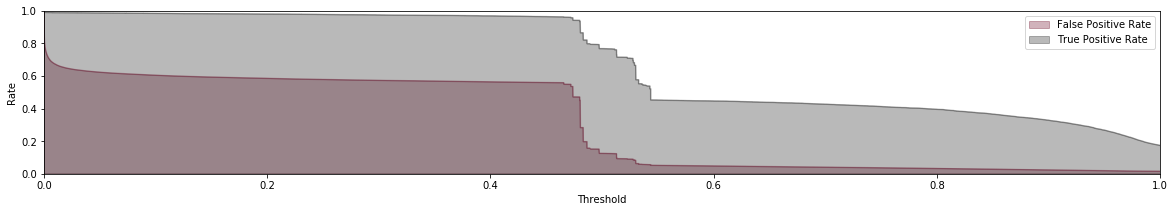

In [18]:
inspector.visualize_auc(fpr,tpr,thresholds)

In [19]:
%matplotlib inline

inspector.display_interactive_cm()

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.05), Output()), _dom_cla…

![Global Shap Report](img/global-shap-report.gif)

In [ ]:
inspector.explain_prediction(data_row_id = 31614)

![Bias Report](img/bp-bias-report.gif)

## __[Optional]__ Deploy Model

In [23]:

execresults = sfn.describe_execution(executionArn=execution_arn)
print(execresults)

{'executionArn': 'arn:aws:states:us-west-1:803235869972:execution:bp-autopilot-blueprint:bcba8129-b226-49dc-bb8a-36779ab5d5dd', 'stateMachineArn': 'arn:aws:states:us-west-1:803235869972:stateMachine:bp-autopilot-blueprint', 'name': 'bcba8129-b226-49dc-bb8a-36779ab5d5dd', 'status': 'SUCCEEDED', 'startDate': datetime.datetime(2021, 4, 5, 20, 25, 19, 34000, tzinfo=tzlocal()), 'stopDate': datetime.datetime(2021, 4, 5, 21, 38, 54, 626000, tzinfo=tzlocal()), 'input': '{"config_uri": "s3://bp-workspace-us-west-1-803235869972/automl-blueprint/config/blueprint-config.json"}', 'inputDetails': {'included': True}, 'output': '[{"ExecutedVersion":"$LATEST","Payload":{"security-config":{"iam_role":"arn:aws:iam::803235869972:role/bp-autopilot-sm-role"},"workspace-config":{"s3_prefix":"automl-blueprint","s3_bucket":"bp-workspace-us-west-1-803235869972"},"data-config":{"raw_in_prefix":"automl-blueprint/sample-data/bank-marketing","prepped_out_prefix":"automl-blueprint/data/prepped","s3_bucket":"bp-works

In [26]:
from sagemaker.model import Model
import sagemaker
from sagemaker import get_execution_role

session = session = sagemaker.session.Session()
role = get_execution_role()

model = session.create_model(name="automl-bp-model-2021-04-05-20-25-19",
                            role= role,
                            )

TypeError: create_model() missing 2 required positional arguments: 'role' and 'container_defs'

In [34]:
from time import strftime, gmtime

now = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
epc_name = f"automl-bp-epc-{now}"
ep_name = f"automl-bp-ep-{now}"
model_name = "automl-bp-model-2021-04-05-20-25-19"



sm.create_endpoint_config(
    EndpointConfigName = epc_name,
    ProductionVariants=[{
        "VariantName":"v1",
        "ModelName":model_name,
        "InitialInstanceCount": 1,
        "InstanceType":"ml.m5.large"
    }])

response = sm.create_endpoint(
    EndpointName= ep_name,
    EndpointConfigName=epc_name
)

print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-west-1:803235869972:endpoint/automl-bp-ep-2021-04-06-03-07-28', 'ResponseMetadata': {'RequestId': '86bb2153-8917-4a6e-b1e4-dbd5257f31e9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '86bb2153-8917-4a6e-b1e4-dbd5257f31e9', 'content-type': 'application/x-amz-json-1.1', 'content-length': '100', 'date': 'Tue, 06 Apr 2021 03:07:29 GMT'}, 'RetryAttempts': 0}}


In [35]:
sm.delete_endpoint(EndpointName=ep_name)

{'ResponseMetadata': {'RequestId': '74781993-181c-4ef7-95d2-c401085c0114',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '74781993-181c-4ef7-95d2-c401085c0114',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 06 Apr 2021 03:31:19 GMT'},
  'RetryAttempts': 0}}